# preprocessing for behavioural data

## workflow:

- you should have done:
    - maze registration 
    - sleap + rois 
- now it's time to output 
    - XY_raw 
        - (tracking that's smoothed, corrected, aligned) -- you can play a
        - shape of array should be ((tracking_length/frame, 2)). the columns being x, y coordinates
    - poke_raw 
        - for all pokes under filename: f"{mouseid}_{date}_poke_raw_{sessnum}.npy"
        - shape of array should be ((num_of_pokes, 2)). with 1st column being poke_in timepoint and 2nd column being poke_out timepoint 
    - LED_raw
        - ONLY if you're doing opto. if not, you can comment out the corresponding section 
        - a 1d array with the length of the video/behaviour data, binary (0 representing light-off, and 1 light-on)
    - Trial_time_array 
        - under filename: f"{mouseid}_{date}_Trial_time_raw_{sessnum}.npy"
        - shape of array should be ((num_of_trials, 5)). the columns are timepoints for (A_on, B_on, C_on, D_on, A_on)
    - Location_raw
        - 1d array, where the animals are at a given timepoint. aligned 

- you should probably, do the sanity check cell as well just to see if the data make sense

- you can play around with the criteria_cm_for_smoothing parameter to see what makes the most sense to smooth your tracking data (try maybe 2-15)

    


In [1]:
import h5py
import numpy as np
import os 
import pandas as pd 
import json
import glob 
from pathlib import Path
import matplotlib.pyplot as plt
import math
from mazeABCD_preprocessing_behaviour.preprocessing_functions import *
from scipy.optimize import least_squares
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

%load_ext autoreload
%autoreload 2


In [3]:
### this is to log the output of the behavioural preprocessing, the log file is saved in the same folder as the behavioural preprocessing script
# Define log file path
log_fp = os.path.join(os.getcwd(), 'mazeABCD_preprocessing_behaviour', 'behavioural_preprocessing.log')
os.makedirs(os.path.dirname(log_fp), exist_ok=True)

# Create or get logger
logger = logging.getLogger('notebook_logger')
logger.setLevel(logging.DEBUG)  # Make sure all levels are allowed

# Remove any existing handlers (important in Jupyter!)
if logger.hasHandlers():
    logger.handlers.clear()

# Create file handler
file_handler = logging.FileHandler(log_fp, mode='a')
file_handler.setLevel(logging.DEBUG)  # Ensure handler accepts all levels

# Formatter
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)

# Add handler to logger
logger.addHandler(file_handler)

# Now write test logs
logger.debug("DEBUG message")
logger.info("INFO message")
logger.warning("WARNING message")
logger.error("ERROR message")

# Force flush (optional, helpful in notebooks)
file_handler.flush()

# Confirm file path
print(f"Logging to: {log_fp}")


DEBUG:notebook_logger:DEBUG message
INFO:notebook_logger:INFO message
ERROR:notebook_logger:ERROR message


Logging to: /ceph/behrens/mingyu_zhu/vHPC_mPFC/code/mazeABCD_preprocessing_behaviour/behavioural_preprocessing.log


In [4]:
### Parameters and filepaths 

## change here 
base_folder =  "/ceph/behrens/mingyu_zhu/vHPC_mPFC"

### things that needs to be changed: 

mouse_ids = ['mz05','mz06','mz07','mz09','mz10']



GET_LED = True ### if you're doing opto, set to True. if not, set to False 
SKIPPING = False ### whether you want to skip sessions that have already been preprocessed, set to True if you want to skip, if set to False, it will replace the existing files 

target_node = 'head_back' ### the animal body node you want to use for the analysis 
num_port = 9 ### the number of ports on the maze 

possible_maze = ['maze1', 'maze2', 'maze2_2'] ### the possible mazes you've done, usually there should be only 'maze1' 'maze2'. 'maze2_2' is maze2 with camere being moved 

criteria_cm_for_smoothing = 12 ### the criteria for the smoothing of the tracking data, you can play around with this parameter to see what makes the most sense to smooth your tracking data (try maybe 2-15)

### parameters that (PROBABLY) don't need to be changed 
reward_state = ['A_on', 'B_on', 'C_on', 'D_on'] ### if you're doing ABCD, if doing ABC, change to ['A_on', 'B_on', 'C_on'] (might need to check the pipeline later although it should work)
### setting up the keys for the pokes 
poke_dict_keys = [] 
poke_order = np.arange(1,10)
for k in poke_order:
    poke_dict_keys.append(f"poke_{k}")
    poke_dict_keys.append(f"poke_{k}_out")


sampling_frequency_pycontrol = 1000/40 ## converting into 25ms time bins 
sampling_frequency_tracking = 60/40




In [9]:
### setting up the filepaths 

behaviour_folder = f"{base_folder}/data/raw_data/behaviour"
roi_folder = f"{base_folder}/data/preprocessed_data/SLEAP_ROIs"
sleap_folder = f"{base_folder}/data/preprocessed_data/SLEAP"
maze_params_folder = f"{base_folder}/code/mazeABCD_preprocessing_maze_registration/maze_params"
metadata_folder = f"{base_folder}/data/raw_data/metadata"
intermediate_folder = f"{base_folder}/data/preprocessed_data/behavioural_raw"
if os.path.isdir(intermediate_folder) == False:
    os.mkdir(intermediate_folder)



tracking_sess = []
pycontrol_sess = []
pinstate_filepath = []
roi_filepath = []
sleap_filepath = []
pycontrol_filepath = []
xy_raw_filepath = []
led_raw_filepath = []
loc_raw_filepath = []
poke_raw_filepath=[]
trial_time_raw_filepath = []
Tasks_filepath=[]
Tasks_info_filepath = []
maze_list = []

    
for key in mouse_ids:
    meta_data_filepath = os.path.join(metadata_folder,f"MetaData_{key}.csv")
    metadata = pd.read_csv(meta_data_filepath)
    recording_dates = np.unique(np.array(metadata['Date']))

    print(f"dealing with subject: {key}")
    for d in recording_dates:
        #print(d)
        subject_date = f"{key}_{d.split('-')[0]}{d.split('-')[1]}{d.split('-')[2]}"
        #date=f"{d.split('/')[2]}-{d.split('/')[1]}-{d.split('/')[0]}"
        tracking_curr= list(metadata.loc[((metadata['Date'] == d) & (metadata['Include'] == 1))]['Tracking'])
        pycontrol_curr = list(metadata.loc[((metadata['Date'] == d) & (metadata['Include'] == 1))]['Behaviour'])
        #print(tracking_curr)
        maze_list_curr = list(metadata.loc[((metadata['Date'] == d) & (metadata['Include'] ==1))]['Maze'])
        #print(maze_list_curr)
        for sess in range(len(tracking_curr)):
            if int(tracking_curr[sess]) < 100000:
                try: 
                    sleap_filepath.append(os.path.join(sleap_folder,[entry.name for entry in os.scandir(sleap_folder) if entry.is_file() and entry.name.startswith(f"{key}_{d}-0{tracking_curr[sess]}.")][0]))
                    roi_filepath.append(os.path.join(roi_folder,f"{key}_{d}-0{tracking_curr[sess]}.csv"))
                except:
                    print(f"sleap_file not found for {key}_{d}_0{tracking_curr[sess]}, skipping")
                    sleap_filepath.append('nosleapfilefound')
                    roi_filepath.append('noroifilefound')
                pinstate_filepath.append(os.path.join(behaviour_folder,f"{key}_pinstate_{d}-0{tracking_curr[sess]}.csv"))
                
                #sleap_filepath.append(os.path.join(sleap_folder,[entry.name for entry in os.scandir(sleap_folder) if entry.is_file() and entry.name.startswith(f"{key}_{d}-0{tracking_curr[sess]}.predicted")][0]))
                pycontrol_filepath.append(os.path.join(behaviour_folder,f"{key}-{d}-0{pycontrol_curr[sess]}.txt"))
                
            else:
                try: 
                    sleap_filepath.append(os.path.join(sleap_folder,[entry.name for entry in os.scandir(sleap_folder) if entry.is_file() and entry.name.startswith(f"{key}_{d}-{tracking_curr[sess]}.")][0]))
                    roi_filepath.append(os.path.join(roi_folder,f"{key}_{d}-{tracking_curr[sess]}.csv"))
                except:
                    print(f"sleap_file not found for {key}_{d}_{tracking_curr[sess]}, skipping")
                    sleap_filepath.append('nosleapfilefound')
                    roi_filepath.append('noroifilefound')
                    
                    
                pinstate_filepath.append(os.path.join(behaviour_folder,f"{key}_pinstate_{d}-{tracking_curr[sess]}.csv"))
                
                #sleap_filepath.append(os.path.join(sleap_folder,[entry.name for entry in os.scandir(sleap_folder) if entry.is_file() and entry.name.startswith(f"{key}_{d}-{tracking_curr[sess]}.predicted")][0]))
                pycontrol_filepath.append(os.path.join(behaviour_folder,f"{key}-{d}-{pycontrol_curr[sess]}.txt"))
            maze_list.append(f"maze{maze_list_curr[sess]}")
            xy_raw_filepath.append(os.path.join(intermediate_folder,f"XY_raw_{subject_date}_{sess}.npy"))
            led_raw_filepath.append(os.path.join(intermediate_folder,f"LED_raw_{subject_date}_{sess}.npy"))
            loc_raw_filepath.append(os.path.join(intermediate_folder,f"Location_raw_{subject_date}_{sess}.npy"))
            trial_time_raw_filepath.append(os.path.join(intermediate_folder,f"trialtimes_{subject_date}_{sess}.npy"))
            poke_raw_filepath.append(os.path.join(intermediate_folder,f"poke_raw_{subject_date}_{sess}"))
            Tasks_filepath.append(os.path.join(intermediate_folder,f"Task_data_{subject_date}_{sess}.npy"))
            Tasks_info_filepath.append(os.path.join(intermediate_folder,f"Task_info_{subject_date}_{sess}.npy"))



            






dealing with subject: mz05
dealing with subject: mz06
dealing with subject: mz07
dealing with subject: mz09
dealing with subject: mz10


In [6]:
#### checking that all of the fp lists have the same length 

print(f"length of sleap fp list: {len(sleap_filepath)},length of roi list: {len(roi_filepath)},length of pycontrol list: {len(pycontrol_filepath)}, length of pinstate list: {len(pinstate_filepath)}")
print(f"length of xy_raw list: {len(xy_raw_filepath)},length of led list: {len(led_raw_filepath)},length of loc list: {len(loc_raw_filepath)}, \n length of trial_time list: {len(trial_time_raw_filepath)},length of task list: {len(trial_time_raw_filepath)}, length of poke list: {len(poke_raw_filepath)}")


length of sleap fp list: 805,length of roi list: 805,length of pycontrol list: 805, length of pinstate list: 805
length of xy_raw list: 805,length of led list: 805,length of loc list: 805, 
 length of trial_time list: 805,length of task list: 805, length of poke list: 805


In [7]:
## checking that the files match -- try a few different indices (n) to see if they match 
n = 177
print(sleap_filepath[n])
print(roi_filepath[n])
print(pycontrol_filepath[n])
print(xy_raw_filepath[n])
print(trial_time_raw_filepath[n])




/ceph/behrens/mingyu_zhu/vHPC_mPFC/data/preprocessed_data/SLEAP/mz06_2024-10-26-184130.predicted_2025-01-26T22:04:59.785987.h5
/ceph/behrens/mingyu_zhu/vHPC_mPFC/data/preprocessed_data/SLEAP_ROIs/mz06_2024-10-26-184130.csv
/ceph/behrens/mingyu_zhu/vHPC_mPFC/data/raw_data/behaviour/mz06-2024-10-26-184159.txt
/ceph/behrens/mingyu_zhu/vHPC_mPFC/data/preprocessed_data/behavioural_raw/XY_raw_mz06_20241026_2.npy
/ceph/behrens/mingyu_zhu/vHPC_mPFC/data/preprocessed_data/behavioural_raw/trialtimes_mz06_20241026_2.npy


In [10]:
### finding the maze parameters that would be later used for undistorting the tracking data 
distortion_coef_dict = dict()
pixel_to_cm_dict = dict()
for val in possible_maze:
    distortion_coef_dict[val] = np.load(f"{maze_params_folder}/{val}_distortion_coefs.npy")
    pixel_to_cm_dict[val] = np.load(f"{maze_params_folder}/{val}_pixel_to_cm.npy")[0]
data_temp = h5py.File(sleap_filepath[1], 'r')
for i in range(len(data_temp['node_names'])):
    if data_temp['node_names'][i].astype(str) != target_node:
        continue
    else:
        node_ind = i 


In [11]:

### this cell generates all of the main behavioural data 
### you can comment out the part that you don't need 


#for f in range(len(sleap_filepath)): 

for f in [177]:
    if SKIPPING:
        if os.path.exists(xy_raw_filepath[f]):
            logger.info(f"session {pycontrol_filepath[f].split('/')[-1]} already exists -- skipping")
            continue

    logger.info(f"dealing with session {pycontrol_filepath[f].split('/')[-1]}")

#II. sanity check before outputting stuffs 
    ### first check if no. of sync pulses match -- if not, there was somethign wrong, would need to double check so let's not do it now. 

    data_pycontrol = open(pycontrol_filepath[f], 'r')
    timestamps_dict = dict()
    for line in data_pycontrol:
        if line[0] == 'V' and line.split(' ')[2] =='active_poke':
            #print(line)
            task_str = (line.split(' ')[-1])[1:-2].split(',')
            task_list = list()
            for j in range(len(task_str)):
            #    print(int(task_str[j]))
                task_list.append(int(task_str[j]))
            timestamps_dict['Task'] = np.array(task_list).tolist()
        elif line[0:11] == 'I Task name':
            task_name = (line.split(':')[1][1:-1])
            timestamps_dict['Task_name'] = task_name
        
        elif line.startswith('S '):  # State definitions
            state_dict = json.loads(line[2:])
        elif line.startswith('E '):  # Event definitions
            events_dict = json.loads(line[2:])
            #with open(f"{preprocessing_params_folder}/event_reference_folder/{task_name}_event_reference.json", 'r') as fp:
            #    event_dict = json.load(fp)
    
    event_dict = events_dict | state_dict
    data_pycontrol = open(pycontrol_filepath[f], 'r')
    event_list = [0,0]
    total_events_count = 0
    for line in data_pycontrol:
        if line[0] != 'D':
            continue
        total_events_count+=1
        if np.sum(event_list)==0:
            event_list[0] = (int(line.split(' ')[1])//sampling_frequency_pycontrol)
            event_list[1] = (int(line.split(' ')[-1][:-1]))
            event_array = np.array(event_list)
        else:
            event_list[0] = (int(line.split(' ')[1])//sampling_frequency_pycontrol)
            event_list[1] = (int(line.split(' ')[-1][:-1]))
            event_array = np.vstack((event_array, np.array(event_list)))
    timestamps = event_array.T[0]
    for key in event_dict.keys():
        ref_num = event_dict[key]
        #print(ref_num)
        event_time_ind = np.where(event_array[:,1] == ref_num)[0]
        event_time = np.array([timestamps[j] for j in event_time_ind]).tolist()
        #print(event_time)
        timestamps_dict[key] = event_time

    pinstate_file = np.loadtxt(pinstate_filepath[f])
    
    pinstate_time_ids = np.unique(pinstate_file)
    ttl_binary_temp = (np.where(pinstate_file == pinstate_time_ids[1])[0])
    if len(ttl_binary_temp)%3 != 0:
        ttl_binary_temp= np.concatenate((ttl_binary_temp, np.zeros((len(ttl_binary_temp)%3))))
    ttl_binary = ttl_binary_temp[np.arange(len(ttl_binary_temp)//(3))*(3)]
    if abs(len(ttl_binary) - len(timestamps_dict['rsync'])) > 1:
        #print(len(ttl_binary),len(txt_dict['rsync']))
        logger.error(f"Numbers of sync pulses don't match, this is session {pycontrol_filepath[f].split('/')[-1]} \n no. of sync pulses: {len(ttl_binary)}, no. of rsync: {len(timestamps_dict['rsync'])}")
        continue



### III. outputting trial_time_raw, poke_raw(s), xy_raw, loc_raw, led_raw all in np.array formats 
    if GET_LED:
        try:
            led_array = get_led(timestamps_dict, event_array, poke_dict_keys, event_dict)
        
        except:
            logger.error(f"Weird, not getting correct light-on/off data. check this session out. this is f = {f}")
            continue
        
    for a, state in enumerate(reward_state):
        if a == 0:
            trial_time_array = np.ndarray(shape = (len(timestamps_dict[state]), len(reward_state)+1))
            trial_time_array[:] = np.nan
            trial_time_array[:,a] = np.array(timestamps_dict[state])
            
        else:
            trial_time_array[:len(timestamps_dict[state]), a] = np.array(timestamps_dict[state])
    
    trial_time_array[:,-1] = np.concatenate((trial_time_array[1:,0],[np.nan]))
    first_A_timestamp = trial_time_array[0,0]

    #### correcting for exception cases in the 
    data_pycontrol = open(pycontrol_filepath[f], 'r')
    light_status_list = []
    for line in data_pycontrol:
        if 'trial' in line:
            light_status_list.append(line[-2:-1])

    if len(trial_time_array) != len(light_status_list):
        logger.warning('Weirdddd -- trial_time_array and light_status_list dont match')

    if np.sum(led_array) != 0 and timestamps_dict['Task_name'] == 'ABCD_withopto_v5':
        trial_time_array_led_state = get_led_state_info(led_array, trial_time_array)
        for tr in range(len(light_status_list)):
            tr_list_curr = [0,0,0,0,0]
            #print(light_status_list[tr])
            tr_list_curr[int(light_status_list[tr])-1] = 1
            if trial_time_array_led_state[tr].tolist() != tr_list_curr:
                if tr == len(trial_time_array) -1 and np.isnan(trial_time_array[tr]).any():
                    continue

                logger.warning(f"weird -- not correct light at trial{tr}, correcting")
                if np.sum(trial_time_array_led_state[tr]) == 0 and int(light_status_list[tr]) == 1:
                    logger.info('LIGHT forced off at A-B before 60s ends because D_A was also light_on')
                    lighton_start = int(trial_time_array[tr][0])
                    lighton_end = int(timestamps_dict['LED_forced_off'][int(np.where(np.array(timestamps_dict['LED_forced_off'])>lighton_start)[0][0])])
                    #print(lighton_start,lighton_end)
                    led_array[lighton_start:lighton_end] = 1
                else:              
                    for sta in range(0,len(reward_state)):
                        if tr_list_curr[sta] == 1:
                            continue
                        else:
                            if np.isnan(trial_time_array[tr][sta+1]):
                                break
                            sta_start = int(trial_time_array[tr][sta])
                            sta_end = int(trial_time_array[tr][sta+1])
                            led_array[sta_start:sta_end] = 0

    trial_time_array = trial_time_array - first_A_timestamp
    trial_time_array = trial_time_array[:-1,:] ### since there would be no scenario where the last row of the trialtime array does not contain any NAN, simply deleting it here
    if trial_time_array.size == 0:
        logger.info("completed less than 1 trial, skipping!")
        continue
    last_A_timestamp = trial_time_array[-1,-1]
    #print(first_A_timestamp, last_A_timestamp)
    ### align led array to first A timestamp
    led_array=led_array[int(first_A_timestamp):int(last_A_timestamp+first_A_timestamp)]

### saving out Tasks info 
    np.save(Tasks_info_filepath[f], timestamps_dict['Task_name'])
    np.save(Tasks_filepath[f], timestamps_dict['Task'])

    ### saving trial_time_array ### outputing the led_raw files 
    np.save(trial_time_raw_filepath[f], trial_time_array)
    np.save(led_raw_filepath[f], led_array)

    ### outputing poke_arrays (aligned to first_A_timestamp)

    

    #### outputing poke_arrays for each port
    '''
    for p in range((num_port)):
        poke_array, weird_port= get_poke_array(timestamps_dict[f"poke_{p+1}"],timestamps_dict[f"poke_{p+1}_out"], first_A_timestamp)
        #print(len(poke_array), f"{poke_raw_filepath[f]}_{p+1}.npy")
        np.save(f"{poke_raw_filepath[f]}_{p+1}.npy", poke_array)
        if weird_port:
            logger.warning(f"port {p+1} behaving weird")
    '''

    #### outputing poke_big_array
    poke_big_array, weird_port_list = get_poke_array_big(timestamps_dict,first_A_timestamp)
    if weird_port_list != []:
        logger.warning(f"weird ports for this session: {weird_port_list}")

    np.save(f"{poke_raw_filepath[f]}.npy", poke_big_array)

    data = h5py.File(sleap_filepath[f], 'r')
    data_track = np.round(data['tracks'][0][:, node_ind, :],decimals = 3).T
    
    roi_curr= pd.read_csv(roi_filepath[f])
    roi_target=np.array(roi_curr[target_node])
    if len(roi_target)!= len(data_track):
        logger.info(f"length of roi: {len(roi_target)}, length of tracking: {len(data_track)}")
        logger.error(f"ROI and tracking length doesn't match!!! -- this is file f = {f}")
        continue
    roi_smoothed, tracking_smoothed, percentage_invalid_transition = smooth_tracking_data_no_interpolation(roi_target,data_track, pixel_to_cm_dict[maze_list[f]], criteria_for_reasonable = criteria_cm_for_smoothing)
    logger.info(f"percentage of invalid transitions: {percentage_invalid_transition}")
    ###sampling rate of camera is 60 Hz so upsampling by 2 and then downsampling by 3 
                    ###to get 40 Hz (match to ephys)
    tracking_smoothed = tracking_smoothed.T
    data_track_upsampled= np.vstack((np.repeat(tracking_smoothed[0],2),np.repeat(tracking_smoothed[1],2))).T 
    data_track_downsampled = data_track_upsampled[np.arange(len(data_track_upsampled)//(3))*(3)]
    #data_track_downsampled = data_track_downsampled.T
    roi_upsampled= np.repeat(roi_smoothed,2)
    roi_downsampled = roi_upsampled[np.arange(len(roi_upsampled)//(3))*(3)]

    data_track_aligned = data_track_downsampled[int(ttl_binary[0]/sampling_frequency_tracking):,:]
    roi_aligned = roi_downsampled[int(ttl_binary[0]/sampling_frequency_tracking):]

        ### undistorting tracking 
    distr_coefs = distortion_coef_dict[maze_list[f]]
    undistorted_tracking = undistort_points(data_track_aligned, distr_coefs)
    undistorted_tracking_aligned_toA = undistorted_tracking[int(first_A_timestamp):int(first_A_timestamp+last_A_timestamp),:]
    roi_aligned_toA = roi_aligned[int(first_A_timestamp):int(first_A_timestamp+last_A_timestamp)]

    if len(undistorted_tracking_aligned_toA)!=len(roi_aligned_toA) or  len(led_array)!=len(roi_aligned_toA):
        logger.error('length of xy_raw, loc_raw, led_raw, dont match', len(undistorted_tracking_aligned_toA), len(roi_aligned_toA),len(led_array))
    
    np.save(xy_raw_filepath[f], undistorted_tracking_aligned_toA)
    np.save(loc_raw_filepath[f], roi_aligned_toA)
    
    
    
    


INFO:notebook_logger:dealing with session mz06-2024-10-26-184159.txt
INFO:notebook_logger:percentage of invalid transitions: 0.0036504216169616637


current task data: [1 5 7 6]
Session 1. Animal completed 10 trials, at reward_ON, the animal is at: [1. 5. 6. 7.],
 positon not detected for 0.012084527066324883 frames


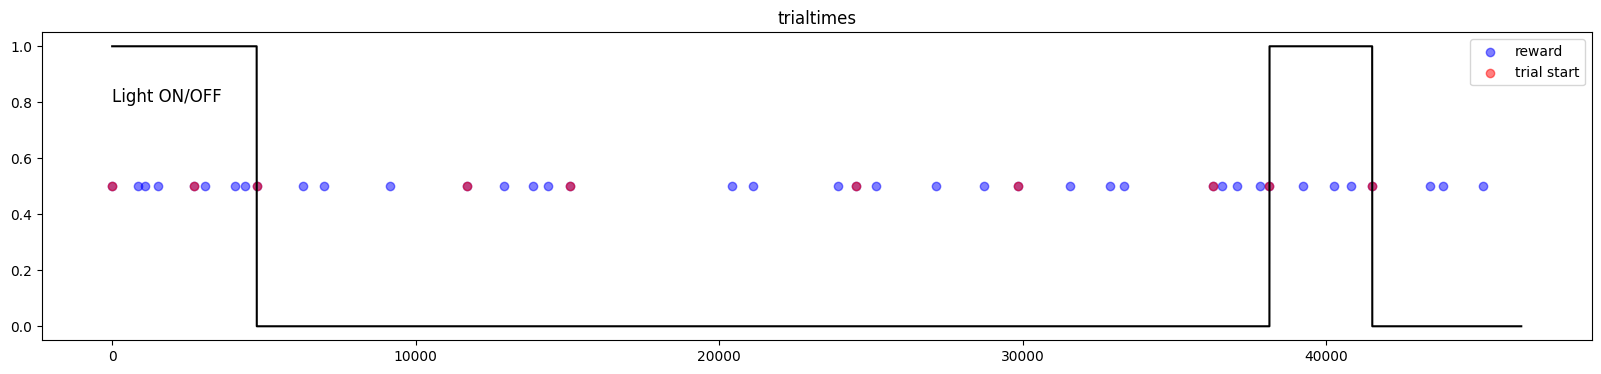

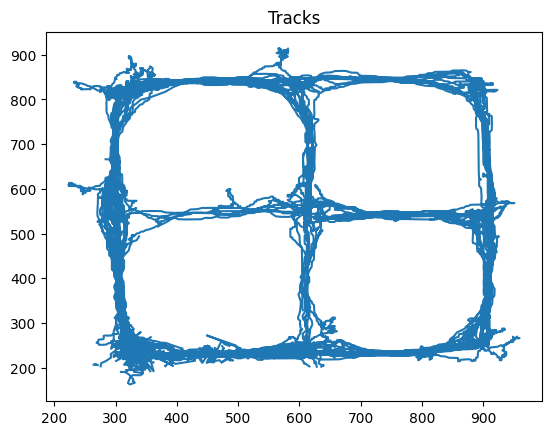

current task data: [1 5 7 6]
Session 2. Animal completed 10 trials, at reward_ON, the animal is at: [1. 5. 6. 7.],
 positon not detected for 0.004255769637941986 frames


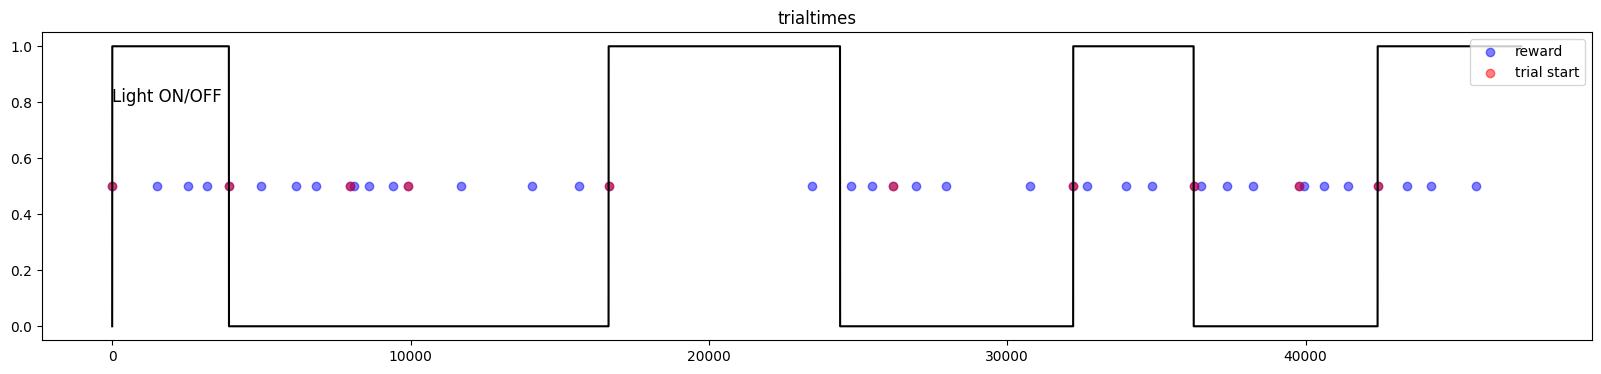

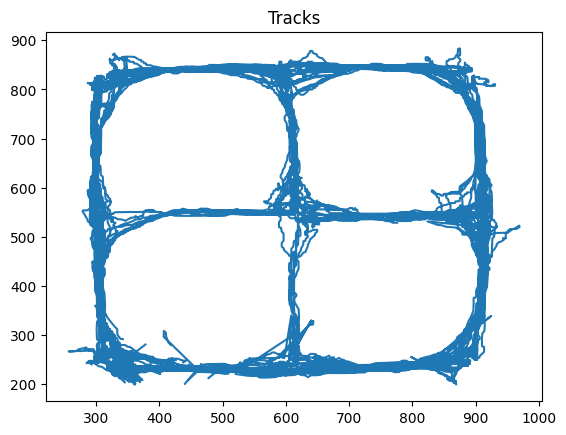

current task data: [1 5 7 6]
Session 3. Animal completed 12 trials, at reward_ON, the animal is at: [1. 5. 6. 7.],
 positon not detected for 0.008191925102399064 frames


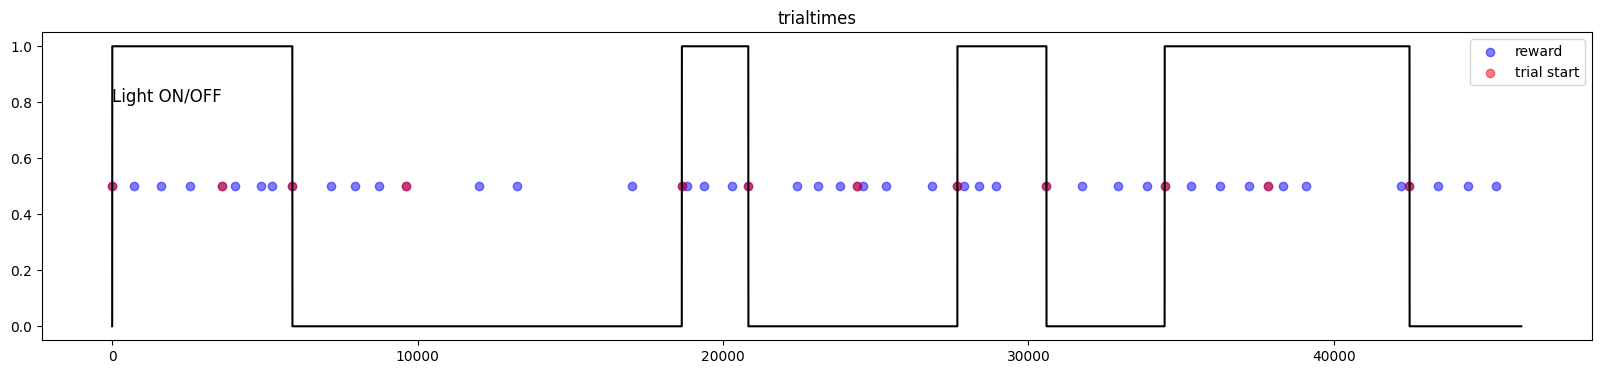

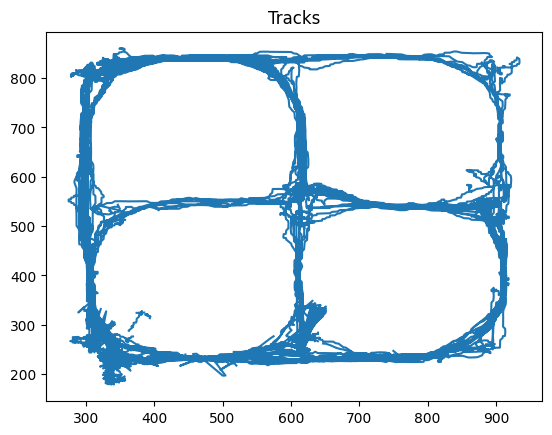

current task data: [1 5 7 6]
Session 4. Animal completed 5 trials, at reward_ON, the animal is at: [1. 5. 6. 7.],
 positon not detected for 0.006844003910859378 frames


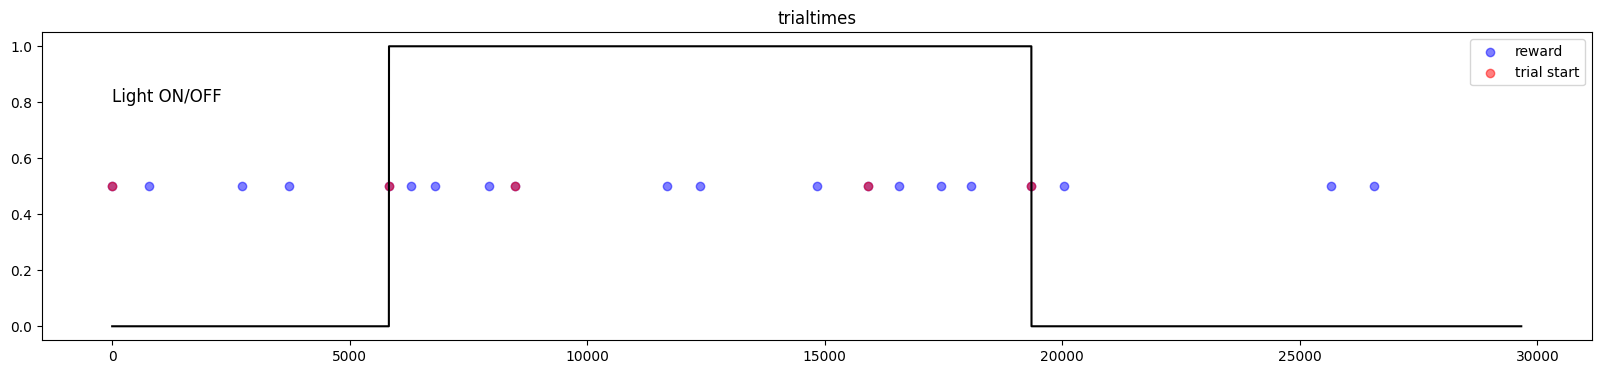

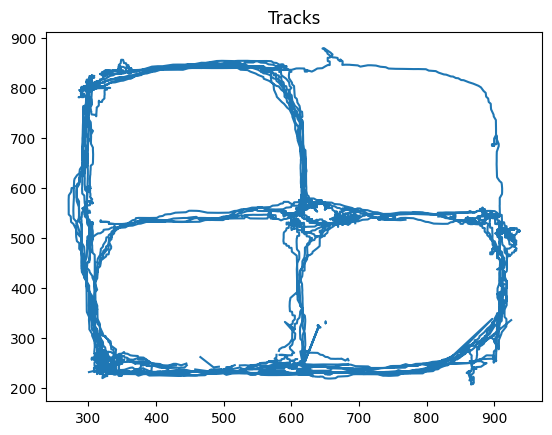

In [85]:
### sanity checking whether the preprocessed data looks alright 

### try out a few recdays 
recday_test = 'mz06_20241025'
num_sess = 5

for sess in range(num_sess):
    try:
        trial_time_array = np.load(f"{intermediate_folder}/trialtimes_{recday_test}_{sess}.npy")
    except:
        continue
    loc_array = np.load(f"{intermediate_folder}/Location_raw_{recday_test}_{sess}.npy")
    xy_array = np.load(f"{intermediate_folder}/XY_raw_{recday_test}_{sess}.npy")
    
    
    task_data = np.load(f"{intermediate_folder}/Task_data_{recday_test}_{sess}.npy")
    print(f"current task data: {task_data}")
    start_time = 0
    end_time = len(loc_array)
    curr_trial_time= trial_time_array[:,:4]
    flat_trial_time = curr_trial_time.flatten()
    flat_trial_time = flat_trial_time[~np.isnan(flat_trial_time)]
    rewarded_loc = [loc_array[int(i)] for i in flat_trial_time]
    invalid_pos = len(np.unique(np.where(np.isnan(xy_array) == True)[0]))
    print(f'Session {sess+1}. Animal completed {len(trial_time_array)} trials, at reward_ON, the animal is at: {np.unique(rewarded_loc)},\n positon not detected for {invalid_pos/len(xy_array)} frames')
    plt.figure(figsize = (20,4))
    plt.scatter(np.where(np.isnan(curr_trial_time), np.nan, curr_trial_time.astype(int)).flatten(), np.tile(0.5, (len(trial_time_array)*4)), color = 'blue', alpha = 0.5, label = 'reward')
    plt.scatter((trial_time_array[:,0]).astype(int).flatten(), np.tile(0.5, (len(trial_time_array))), color = 'red', alpha = 0.5, label = 'trial start')
    plt.legend(loc='upper right')
    plt.title('trialtimes')
    
    if GET_LED:
        led_array = np.load(f"{intermediate_folder}/LED_raw_{recday_test}_{sess}.npy")
        plt.plot(np.arange(len(led_array[start_time:end_time])), led_array[start_time:end_time], color = 'black')
        plt.text(0.5, 0.8, 'Light ON/OFF', fontsize = 12, color = 'black')
    
    
    plt.show()
    plt.plot(xy_array[:,0], xy_array[:,1])
    plt.title('Tracks')
    plt.show()